# Homework 4 (Ibotta Products)

In [1]:
# import analysis packages
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, Flatten, SimpleRNN, TextVectorization
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

/Users/akiehl/miniconda3/envs/dsci/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/akiehl/miniconda3/envs/dsci/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fil

### Data Preprocessing

In [2]:
# read data from .csv files
trainDF = pd.read_csv('./ibotta_train.csv')
testDF = pd.read_csv('./ibotta_test.csv')

# combine data sets for preprocessing
trainDF['origin'] = 'train'
testDF['origin'] = 'test'
fullDF = pd.concat([trainDF, testDF])

In [3]:
# text cleaning
fullDF['Brand_name'].where(-fullDF['Brand_name'].isna(), '', inplace = True)
fullDF['Brand_name'] = fullDF['Brand_name'].apply(lambda x: x.lower().replace("'", "").replace(",", "").replace(":", "").replace("-", "").replace(".", ""))
fullDF['Name'] = fullDF['Name'].apply(lambda x: x.lower().replace("'", "").replace(",", "").replace(":", "").replace("-", "").replace(".", ""))

# combine brand and name fields
fullDF['brandAlready'] = fullDF.apply(lambda x: x['Name'].find(x['Brand_name']), axis = 1)
fullDF.loc[fullDF.brandAlready == -1, 'Name'] = fullDF.loc[fullDF.brandAlready == -1, 'Brand_name'] + \
    ' ' + fullDF.loc[fullDF.brandAlready == -1, 'Name']
fullDF.drop('brandAlready', axis = 1, inplace = True)

In [4]:
# seed random seed
random.seed(542023)

# split data
trainDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'train'].drop('origin', axis = 1))
validIdx = random.sample(list(trainDF['Id'] - 1), 1000)
validDF = trainDF.loc[validIdx]
trainDF = trainDF.loc[trainDF['Id'].apply(lambda x: x not in validIdx)]
testDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'test'].drop(['origin', 'Category'], axis = 1))

# check dimensions of data
display(trainDF.shape)
display(validDF.shape)
display(testDF.shape)

# check data types
display(trainDF.info())

# peek at data
display(trainDF.head())

(7000, 5)

(1000, 5)

(1999, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          7000 non-null   int64  
 1   Name        7000 non-null   object 
 2   Brand_name  7000 non-null   object 
 3   Category    7000 non-null   object 
 4   Cat_code    7000 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 328.1+ KB


None

,Id,Name,Brand_name,Category,Cat_code
0,1,4c homestyle parmesan grated cheese 6 oz,4c,Dairy,2.0
1,2,4c 100% natural parmesan cheese 6 oz,,Dairy,2.0
2,3,4c parmesan & romano cheese grated,4c,Dairy,2.0
3,4,advance fast fixin country fried steaks with g...,fast fixin,Frozen Foods,3.0
5,6,borden dairy company borden natural medium che...,borden dairy company,Dairy,2.0


### Text Vectorization

In [5]:
# find total number of unique words
unique_words = np.unique(np.array(' '.join(np.array(fullDF['Name'])).split(' ')))
max_length = len(unique_words)

# initialize empty dataframe
wordBag = pd.DataFrame(np.zeros((len(fullDF), max_length)), 
                       columns = unique_words)

# loop through product names
for i, productName in enumerate(fullDF['Name'].apply(lambda x: x.split(' '))):
    # loop through words in name
    for word in productName:
        # identify word presence
        wordBag.loc[i, word] = 1

# peek at bag of words
display(wordBag.head())

# split word bag
trainDFwordBag = wordBag.loc[0:7999]
validDFwordBag = trainDFwordBag.loc[validIdx]
trainDFwordBag = trainDFwordBag.loc[pd.Series(trainDFwordBag.index).apply(lambda x: x not in validIdx)]
testDFwordBag = wordBag.loc[8000:9999]

# check dimensions of data
display(trainDFwordBag.shape)
display(validDFwordBag.shape)
display(testDFwordBag.shape)

,,%,&,(101731),(12,(175,(18,(187,(4,(4th,...,zings,zip,zippak¨∆,zipçƒîpak,ziti,zoi,zucchini,|,çƒî,çƒï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(7000, 4977)

(1000, 4977)

(1999, 4977)

In [6]:
# tag data with iterable object
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(fullDF['Name'].apply(lambda x: x.split(' ')))]

# doc2vec vectorization function
def doc2vecGen(size):
    # train doc2vec tokenizer
    tokenizer = Doc2Vec(tagged_data, vector_size = size, min_count = 1, epochs = 100)
    tokenizer.build_vocab(list(tagged_data))
    tokenizer.train(list(tagged_data), 
                    total_examples = tokenizer.corpus_count, 
                    epochs = tokenizer.epochs)
    
    # vectorize text data
    doc2vecDF = fullDF['Name'].apply(lambda x: tokenizer.infer_vector(x.split(' ')))
    doc2vecDF = pd.DataFrame(np.array(doc2vecDF))[0].apply(pd.Series)

    # split vectorized data
    trainDFdoc2vec = doc2vecDF.loc[0:7999]
    validDFdoc2vec = doc2vecDF.loc[validIdx]
    trainDFdoc2vec = trainDFdoc2vec.loc[pd.Series(trainDFdoc2vec.index).apply(lambda x: x not in validIdx)]
    testDFdoc2vec = doc2vecDF.loc[8000:9999]

    return(trainDFdoc2vec, validDFdoc2vec, testDFdoc2vec)

# generate vectorized data
trainDFdoc2vecMAX, validDFdoc2vecMAX, testDFdoc2vecMAX = doc2vecGen(max_length)
trainDFdoc2vec1000, validDFdoc2vec1000, testDFdoc2vec1000 = doc2vecGen(1000)
trainDFdoc2vec500, validDFdoc2vec500, testDFdoc2vec500 = doc2vecGen(500)
trainDFdoc2vec100, validDFdoc2vec100, testDFdoc2vec100 = doc2vecGen(100)

In [7]:
# keras tokenizer function
def textVecGen(size):
    # train keras tokenizer
    tokenizer = TextVectorization(max_tokens = size, 
                                  output_sequence_length = size)
    tokenizer.adapt(fullDF['Name'])

    # vectorize data
    textVecDF = pd.DataFrame(tokenizer(fullDF['Name']))
    
    # split vectorized data
    trainDFtextVec = textVecDF.loc[0:7999]
    validDFtextVec = trainDFtextVec.loc[validIdx]
    trainDFtextVec = trainDFtextVec.loc[pd.Series(trainDFtextVec.index).apply(lambda x: x not in validIdx)]
    testDFtextVec = textVecDF.loc[8000:9999]

    return(trainDFtextVec, validDFtextVec, testDFtextVec)

# generate vectorized data
trainDFtextVecMAX, validDFtextVecMAX, testDFtextVecMAX = textVecGen(max_length)
trainDFtextVec1000, validDFtextVec1000, testDFtextVec1000 = textVecGen(1000)
trainDFtextVec500, validDFtextVec500, testDFtextVec500 = textVecGen(500)
trainDFtextVec100, validDFtextVec100, testDFtextVec100 = textVecGen(100)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-05 16:23:41.846138: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Model Fitting

In [8]:
# model evaluation function
def EvaluateModel(model, X_train):
    # set random seeds
    np.random.seed(542023)
    tf.random.set_seed(542023)

    # print model summary
    try:
        model.summary()
    except:
        pass

    # define F1 metric
    f1_score_metric = F1Score(num_classes = 7, average = 'weighted')

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy', f1_score_metric])
    
    # define early stopping criterion
    early = EarlyStopping(monitor = 'val_f1_score', mode = 'max', patience = 3)

    # train deep learning model
    trained = model.fit(X_train,
                        to_categorical(trainDF['Cat_code']),
                        epochs = 100,
                        batch_size = 128,
                        callbacks = early,
                        validation_split = 0.15,
                        verbose = 1)
    
    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    f1_score = trained.history['f1_score']
    val_f1_score = trained.history['val_f1_score']
    epochs = range(1, len(acc) + 1)

    # final validation accuracy
    display(f"Internal validation accuracy: {round(val_acc[-1] * 100, 2)}%")
    display(f'Internal validation F1 score: {round(val_f1_score[-1], 4)}')

    # plot training accuracy
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 5))
    ax1.plot(epochs, acc, 'bo', label = 'Training acc')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation acc')
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    ax1.legend()
    ax2.plot(epochs, loss, 'bo', label = 'Training loss')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation loss')
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    ax2.legend()
    ax3.plot(epochs, f1_score, 'bo', label = 'Training F1')
    ax3.plot(epochs, val_f1_score, 'b', label = 'Validation F1')
    ax3.set(xlabel = 'Epochs', ylabel = 'F1 Score')
    ax3.legend()
    fig.suptitle('Evaluation Metrics')

### Bag of Words

Epoch 1/100
47/47 [==============================] - 2s 33ms/step - loss: 0.9604 - accuracy: 0.6855 - f1_score: 0.6797 - val_loss: 0.6749 - val_accuracy: 0.8276 - val_f1_score: 0.8288
Epoch 2/100
47/47 [==============================] - 1s 26ms/step - loss: 0.3155 - accuracy: 0.9326 - f1_score: 0.9325 - val_loss: 0.6843 - val_accuracy: 0.8152 - val_f1_score: 0.8195
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 0.2133 - accuracy: 0.9482 - f1_score: 0.9481 - val_loss: 0.6357 - val_accuracy: 0.8505 - val_f1_score: 0.8502
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 0.1517 - accuracy: 0.9644 - f1_score: 0.9643 - val_loss: 0.7527 - val_accuracy: 0.8400 - val_f1_score: 0.8402
Epoch 5/100
47/47 [==============================] - 1s 21ms/step - loss: 0.1074 - accuracy: 0.9706 - f1_score: 0.9706 - val_loss: 0.7878 - val_accuracy: 0.8333 - val_f1_score: 0.8340
Epoch 6/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0820

'Internal validation accuracy: 83.52%'

'Internal validation F1 score: 0.8336'

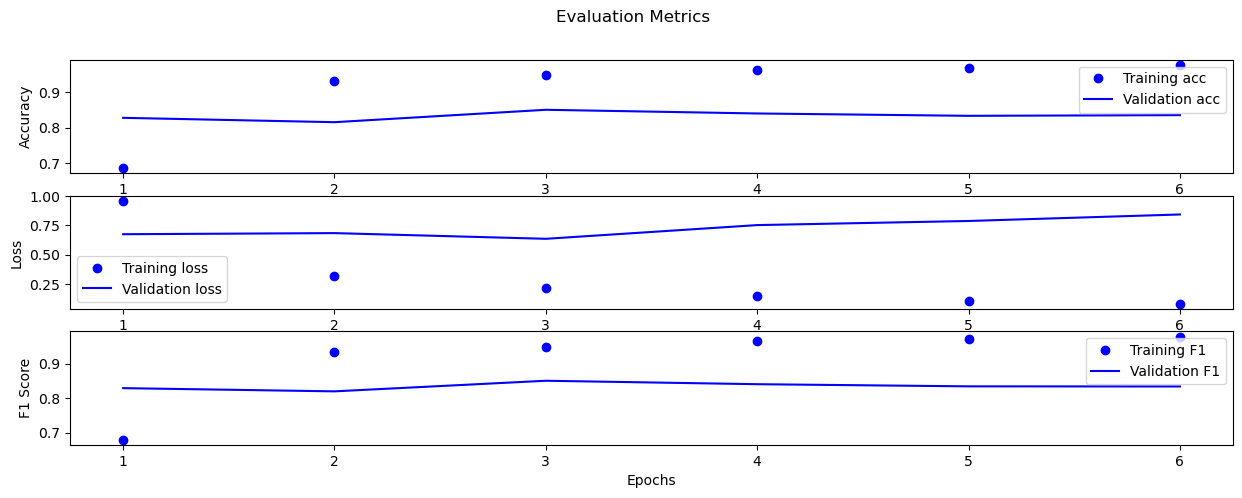

In [14]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)

Epoch 1/100
47/47 [==============================] - 3s 54ms/step - loss: 0.9792 - accuracy: 0.6701 - f1_score: 0.6578 - val_loss: 0.6988 - val_accuracy: 0.8352 - val_f1_score: 0.8347
Epoch 2/100
47/47 [==============================] - 2s 42ms/step - loss: 0.3235 - accuracy: 0.9314 - f1_score: 0.9313 - val_loss: 0.9417 - val_accuracy: 0.7419 - val_f1_score: 0.7504
Epoch 3/100
47/47 [==============================] - 2s 41ms/step - loss: 0.2157 - accuracy: 0.9518 - f1_score: 0.9517 - val_loss: 0.7294 - val_accuracy: 0.8514 - val_f1_score: 0.8518
Epoch 4/100
47/47 [==============================] - 2s 42ms/step - loss: 0.1522 - accuracy: 0.9650 - f1_score: 0.9650 - val_loss: 0.7981 - val_accuracy: 0.8371 - val_f1_score: 0.8372
Epoch 5/100
47/47 [==============================] - 2s 41ms/step - loss: 0.1024 - accuracy: 0.9743 - f1_score: 0.9743 - val_loss: 0.8734 - val_accuracy: 0.8267 - val_f1_score: 0.8276
Epoch 6/100
47/47 [==============================] - 2s 41ms/step - loss: 0.0724

'Internal validation accuracy: 83.33%'

'Internal validation F1 score: 0.8328'

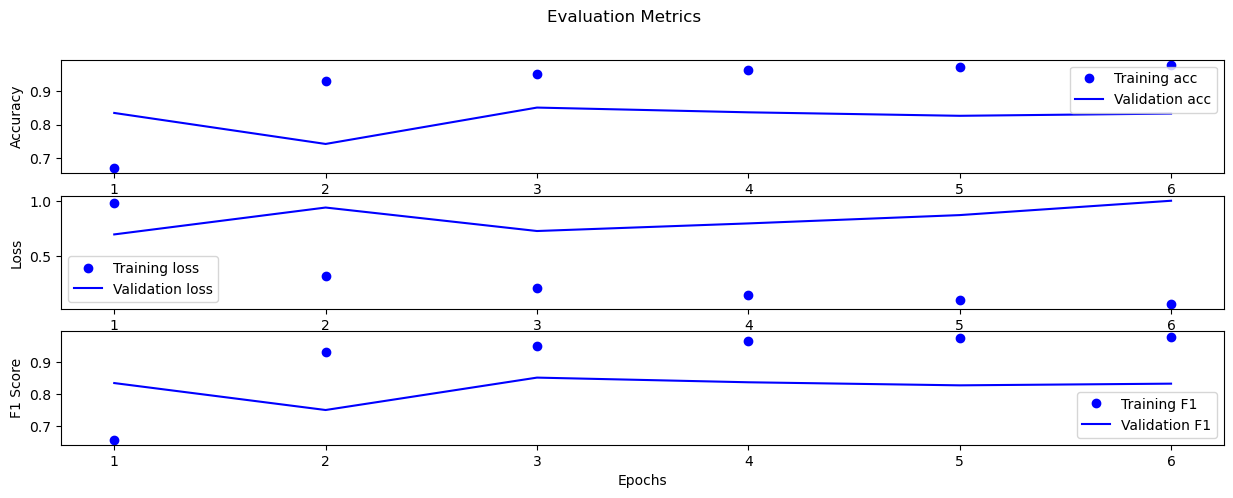

In [15]:
# define model architecture
model = Sequential([
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)

Epoch 1/100
47/47 [==============================] - 4s 63ms/step - loss: 2.5628 - accuracy: 0.5946 - f1_score: 0.5689 - val_loss: 1.3837 - val_accuracy: 0.8114 - val_f1_score: 0.8062
Epoch 2/100
47/47 [==============================] - 2s 50ms/step - loss: 0.9751 - accuracy: 0.8965 - f1_score: 0.8962 - val_loss: 1.1438 - val_accuracy: 0.8210 - val_f1_score: 0.8225
Epoch 3/100
47/47 [==============================] - 3s 53ms/step - loss: 0.7394 - accuracy: 0.9208 - f1_score: 0.9207 - val_loss: 0.9666 - val_accuracy: 0.8352 - val_f1_score: 0.8356
Epoch 4/100
47/47 [==============================] - 2s 48ms/step - loss: 0.6302 - accuracy: 0.9262 - f1_score: 0.9261 - val_loss: 0.8891 - val_accuracy: 0.8486 - val_f1_score: 0.8479
Epoch 5/100
47/47 [==============================] - 2s 48ms/step - loss: 0.5670 - accuracy: 0.9306 - f1_score: 0.9305 - val_loss: 0.8560 - val_accuracy: 0.8448 - val_f1_score: 0.8447
Epoch 6/100
47/47 [==============================] - 2s 48ms/step - loss: 0.5134

'Internal validation accuracy: 82.57%'

'Internal validation F1 score: 0.8268'

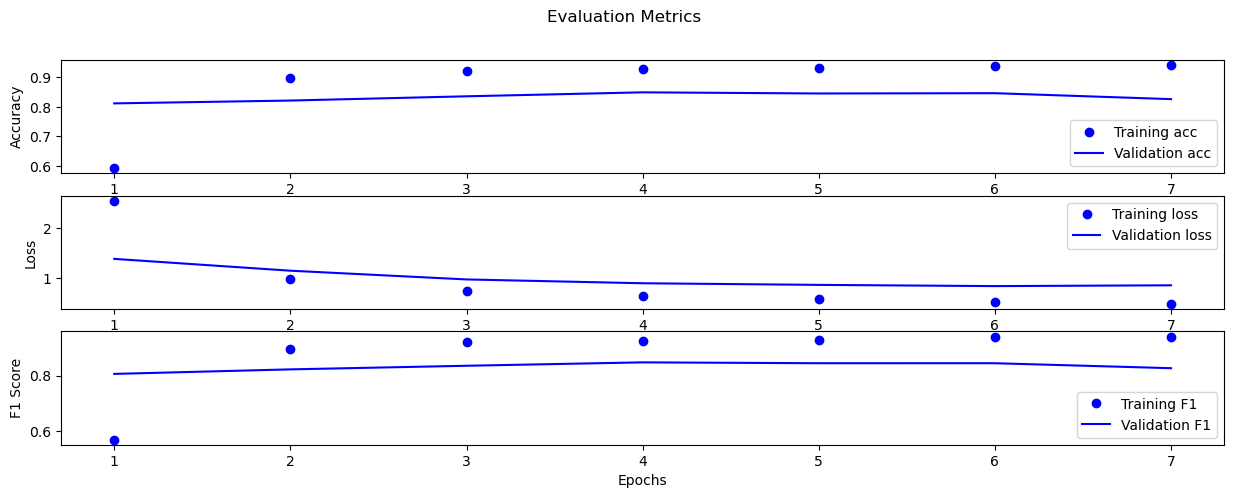

In [16]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)

### Doc2Vec

Epoch 1/100
47/47 [==============================] - 2s 31ms/step - loss: 1.6429 - accuracy: 0.3797 - f1_score: 0.3295 - val_loss: 1.5943 - val_accuracy: 0.4048 - val_f1_score: 0.3609
Epoch 2/100
47/47 [==============================] - 1s 24ms/step - loss: 1.3144 - accuracy: 0.5395 - f1_score: 0.5265 - val_loss: 1.6872 - val_accuracy: 0.4076 - val_f1_score: 0.3947
Epoch 3/100
47/47 [==============================] - 1s 23ms/step - loss: 1.1621 - accuracy: 0.5987 - f1_score: 0.5900 - val_loss: 1.3828 - val_accuracy: 0.5057 - val_f1_score: 0.5083
Epoch 4/100
47/47 [==============================] - 1s 22ms/step - loss: 1.0274 - accuracy: 0.6518 - f1_score: 0.6455 - val_loss: 1.4062 - val_accuracy: 0.5229 - val_f1_score: 0.5176
Epoch 5/100
47/47 [==============================] - 1s 21ms/step - loss: 0.9072 - accuracy: 0.6911 - f1_score: 0.6869 - val_loss: 1.4026 - val_accuracy: 0.5362 - val_f1_score: 0.5326
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.8008

'Internal validation accuracy: 57.05%'

'Internal validation F1 score: 0.5796'

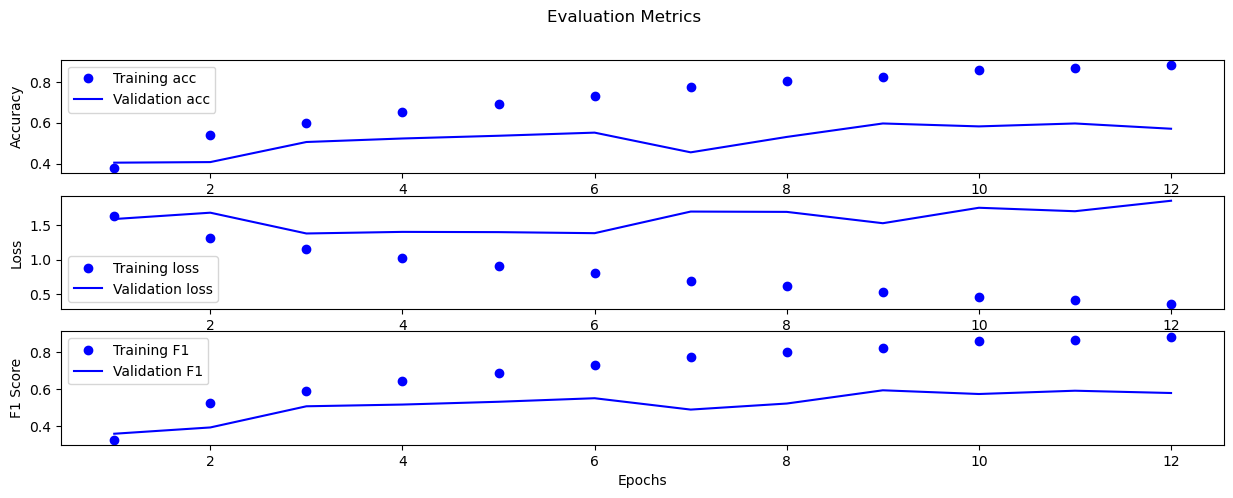

In [17]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vecMAX)

Epoch 1/100
47/47 [==============================] - 4s 64ms/step - loss: 3.2064 - accuracy: 0.2891 - f1_score: 0.2129 - val_loss: 2.2083 - val_accuracy: 0.2467 - val_f1_score: 0.0976
Epoch 2/100
47/47 [==============================] - 2s 48ms/step - loss: 1.9731 - accuracy: 0.3020 - f1_score: 0.2209 - val_loss: 2.1442 - val_accuracy: 0.2219 - val_f1_score: 0.0973
Epoch 3/100
47/47 [==============================] - 2s 50ms/step - loss: 1.8362 - accuracy: 0.3299 - f1_score: 0.2396 - val_loss: 1.9233 - val_accuracy: 0.2390 - val_f1_score: 0.1241
Epoch 4/100
47/47 [==============================] - 2s 51ms/step - loss: 1.7493 - accuracy: 0.3872 - f1_score: 0.3035 - val_loss: 1.8534 - val_accuracy: 0.3514 - val_f1_score: 0.2716
Epoch 5/100
47/47 [==============================] - 2s 48ms/step - loss: 1.6978 - accuracy: 0.4380 - f1_score: 0.3543 - val_loss: 1.8220 - val_accuracy: 0.3714 - val_f1_score: 0.2868
Epoch 6/100
47/47 [==============================] - 2s 48ms/step - loss: 1.6425

'Internal validation accuracy: 49.14%'

'Internal validation F1 score: 0.4751'

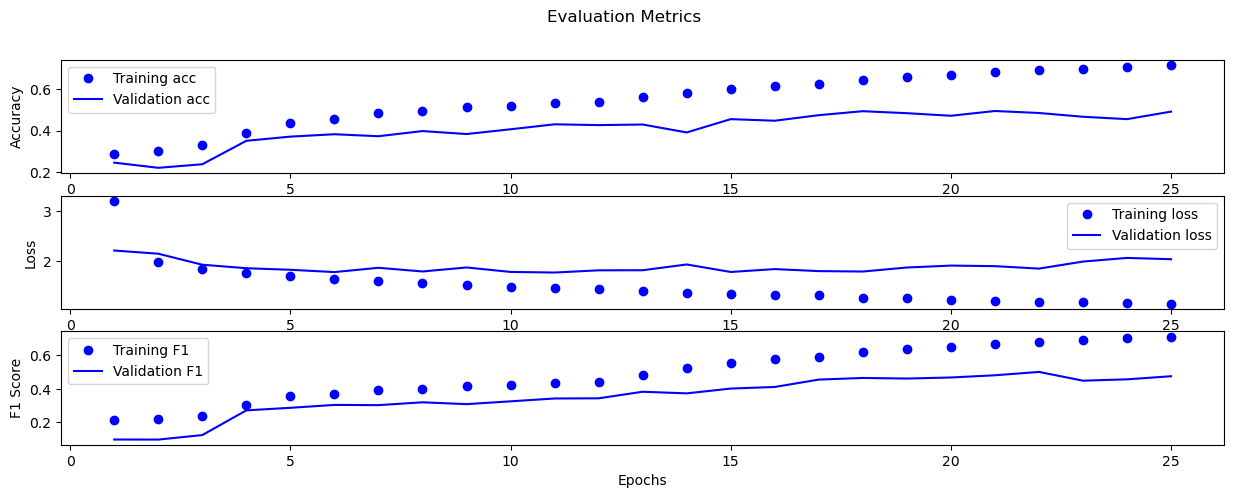

In [18]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vecMAX)

Epoch 1/100
47/47 [==============================] - 2s 32ms/step - loss: 1.6364 - accuracy: 0.3723 - f1_score: 0.3156 - val_loss: 1.5842 - val_accuracy: 0.4219 - val_f1_score: 0.3652
Epoch 2/100
47/47 [==============================] - 1s 21ms/step - loss: 1.3112 - accuracy: 0.5403 - f1_score: 0.5211 - val_loss: 1.5788 - val_accuracy: 0.4276 - val_f1_score: 0.4236
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 1.1372 - accuracy: 0.6071 - f1_score: 0.5987 - val_loss: 1.3510 - val_accuracy: 0.5305 - val_f1_score: 0.5290
Epoch 4/100
47/47 [==============================] - 1s 19ms/step - loss: 0.9931 - accuracy: 0.6703 - f1_score: 0.6640 - val_loss: 1.4281 - val_accuracy: 0.5295 - val_f1_score: 0.5340
Epoch 5/100
47/47 [==============================] - 1s 19ms/step - loss: 0.8747 - accuracy: 0.7044 - f1_score: 0.7004 - val_loss: 1.5544 - val_accuracy: 0.5095 - val_f1_score: 0.4991
Epoch 6/100
47/47 [==============================] - 1s 19ms/step - loss: 0.7680

'Internal validation accuracy: 54.86%'

'Internal validation F1 score: 0.5418'

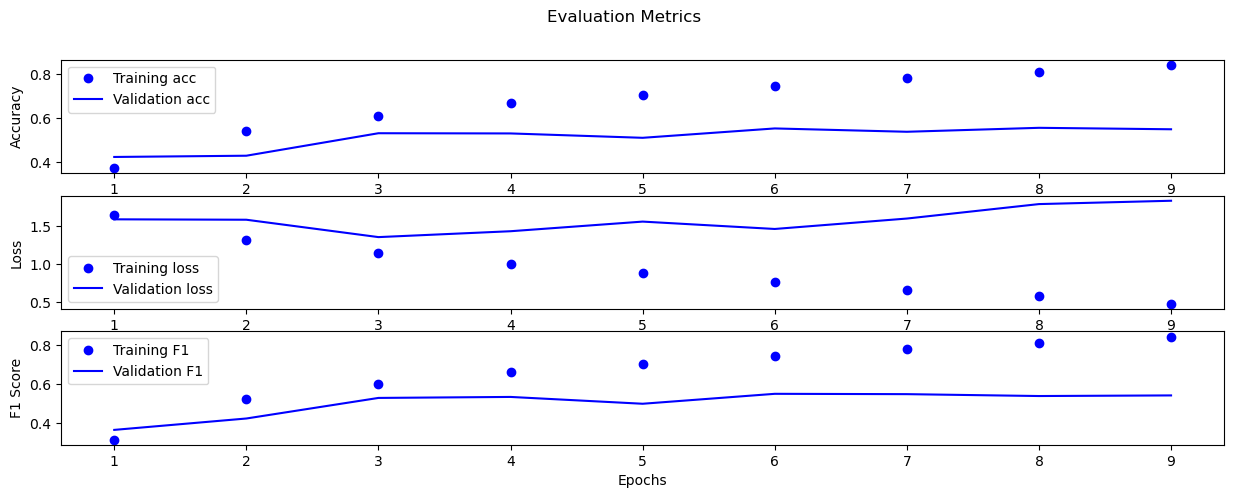

In [19]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Epoch 1/100
47/47 [==============================] - 4s 52ms/step - loss: 3.0948 - accuracy: 0.2867 - f1_score: 0.2126 - val_loss: 2.2111 - val_accuracy: 0.2467 - val_f1_score: 0.0976
Epoch 2/100
47/47 [==============================] - 2s 35ms/step - loss: 1.9393 - accuracy: 0.3022 - f1_score: 0.2306 - val_loss: 2.0540 - val_accuracy: 0.2667 - val_f1_score: 0.1428
Epoch 3/100
47/47 [==============================] - 2s 35ms/step - loss: 1.7694 - accuracy: 0.3370 - f1_score: 0.2449 - val_loss: 1.8562 - val_accuracy: 0.3181 - val_f1_score: 0.2623
Epoch 4/100
47/47 [==============================] - 2s 34ms/step - loss: 1.7121 - accuracy: 0.3390 - f1_score: 0.2457 - val_loss: 1.8319 - val_accuracy: 0.2848 - val_f1_score: 0.1728
Epoch 5/100
47/47 [==============================] - 2s 34ms/step - loss: 1.6814 - accuracy: 0.3526 - f1_score: 0.2792 - val_loss: 1.8135 - val_accuracy: 0.3229 - val_f1_score: 0.2157
Epoch 6/100
47/47 [==============================] - 2s 33ms/step - loss: 1.6348

'Internal validation accuracy: 32.57%'

'Internal validation F1 score: 0.2482'

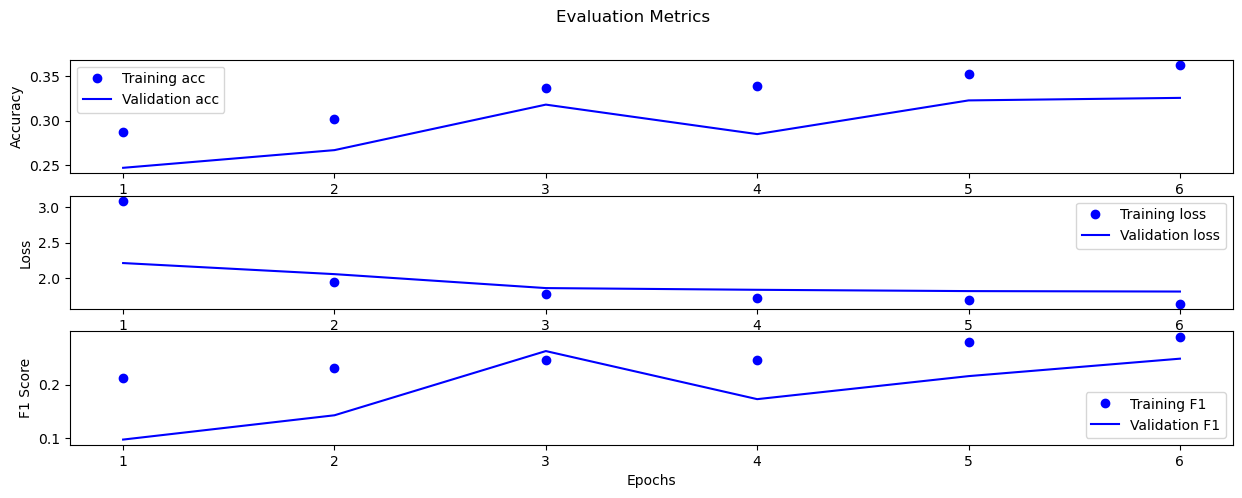

In [20]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Epoch 1/100
47/47 [==============================] - 2s 33ms/step - loss: 1.6447 - accuracy: 0.3713 - f1_score: 0.3102 - val_loss: 1.6375 - val_accuracy: 0.4019 - val_f1_score: 0.3534
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 1.3208 - accuracy: 0.5375 - f1_score: 0.5121 - val_loss: 1.5369 - val_accuracy: 0.4467 - val_f1_score: 0.4440
Epoch 3/100
47/47 [==============================] - 1s 21ms/step - loss: 1.1481 - accuracy: 0.6141 - f1_score: 0.6035 - val_loss: 1.3669 - val_accuracy: 0.5362 - val_f1_score: 0.5385
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 1.0030 - accuracy: 0.6585 - f1_score: 0.6521 - val_loss: 1.5173 - val_accuracy: 0.5019 - val_f1_score: 0.5016
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 0.8893 - accuracy: 0.6982 - f1_score: 0.6942 - val_loss: 1.4879 - val_accuracy: 0.5038 - val_f1_score: 0.5032
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 0.7640

'Internal validation accuracy: 54.48%'

'Internal validation F1 score: 0.5349'

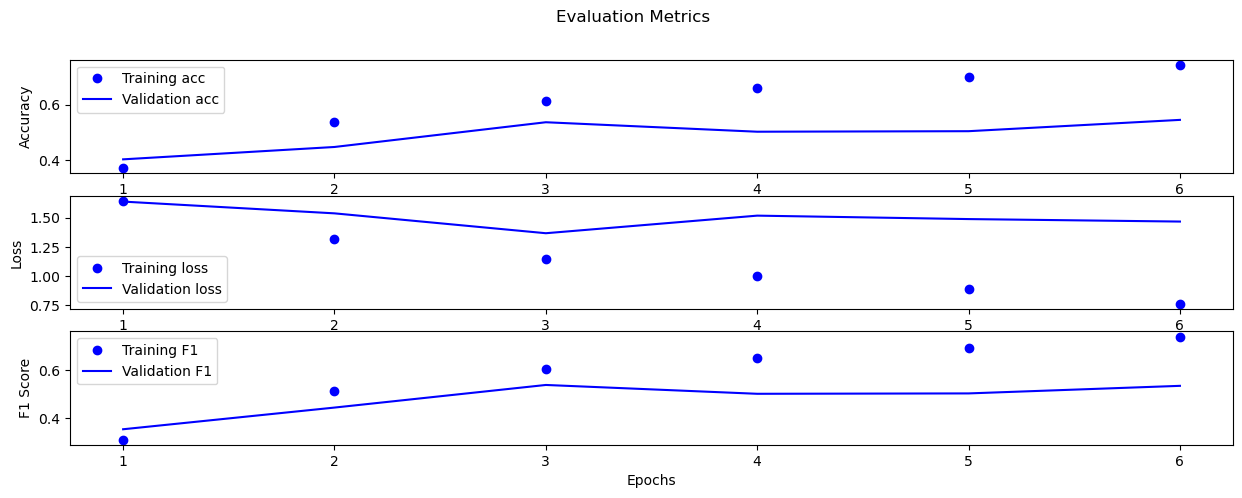

In [21]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec500)

Epoch 1/100
47/47 [==============================] - 3s 50ms/step - loss: 3.0433 - accuracy: 0.3003 - f1_score: 0.2231 - val_loss: 2.2533 - val_accuracy: 0.2657 - val_f1_score: 0.1400
Epoch 2/100
47/47 [==============================] - 2s 32ms/step - loss: 1.9462 - accuracy: 0.4071 - f1_score: 0.3263 - val_loss: 2.0947 - val_accuracy: 0.3362 - val_f1_score: 0.2646
Epoch 3/100
47/47 [==============================] - 1s 30ms/step - loss: 1.7270 - accuracy: 0.4625 - f1_score: 0.3771 - val_loss: 1.8164 - val_accuracy: 0.4200 - val_f1_score: 0.3485
Epoch 4/100
47/47 [==============================] - 1s 30ms/step - loss: 1.6000 - accuracy: 0.5067 - f1_score: 0.4311 - val_loss: 1.7259 - val_accuracy: 0.4352 - val_f1_score: 0.3576
Epoch 5/100
47/47 [==============================] - 1s 31ms/step - loss: 1.5087 - accuracy: 0.5477 - f1_score: 0.4914 - val_loss: 1.8711 - val_accuracy: 0.3819 - val_f1_score: 0.3185
Epoch 6/100
47/47 [==============================] - 1s 31ms/step - loss: 1.4380

'Internal validation accuracy: 49.9%'

'Internal validation F1 score: 0.5096'

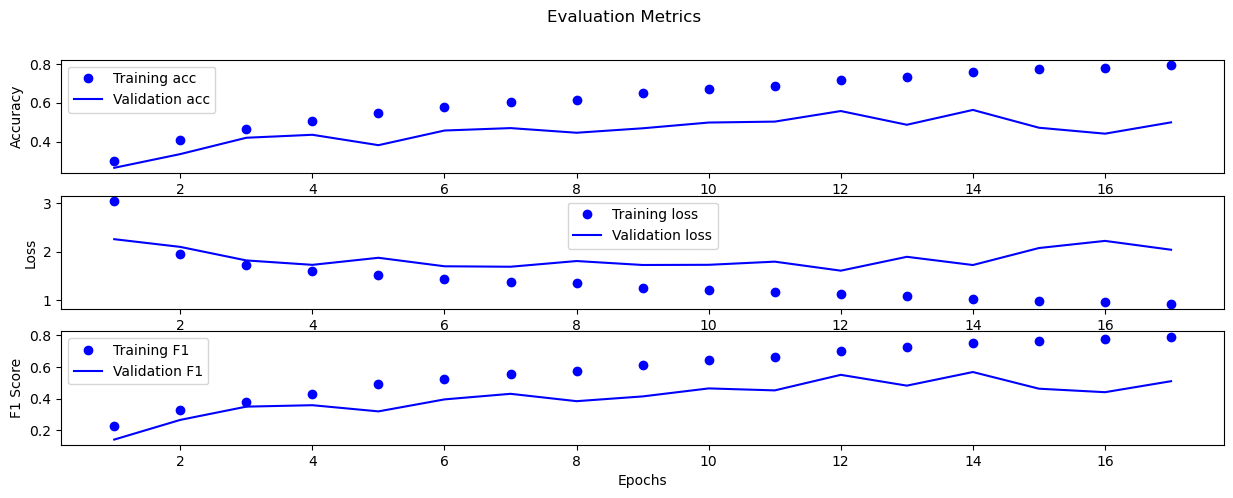

In [22]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec500)

Epoch 1/100
47/47 [==============================] - 2s 33ms/step - loss: 1.6642 - accuracy: 0.3553 - f1_score: 0.2900 - val_loss: 1.6358 - val_accuracy: 0.3867 - val_f1_score: 0.3274
Epoch 2/100
47/47 [==============================] - 1s 21ms/step - loss: 1.3809 - accuracy: 0.5047 - f1_score: 0.4751 - val_loss: 1.6768 - val_accuracy: 0.3676 - val_f1_score: 0.3358
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 1.2262 - accuracy: 0.5770 - f1_score: 0.5652 - val_loss: 1.4254 - val_accuracy: 0.4905 - val_f1_score: 0.4906
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 1.0931 - accuracy: 0.6313 - f1_score: 0.6229 - val_loss: 1.5477 - val_accuracy: 0.4790 - val_f1_score: 0.4600
Epoch 5/100
47/47 [==============================] - 1s 21ms/step - loss: 1.0036 - accuracy: 0.6576 - f1_score: 0.6510 - val_loss: 1.4329 - val_accuracy: 0.5057 - val_f1_score: 0.5058
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 0.8940

'Internal validation accuracy: 53.71%'

'Internal validation F1 score: 0.5319'

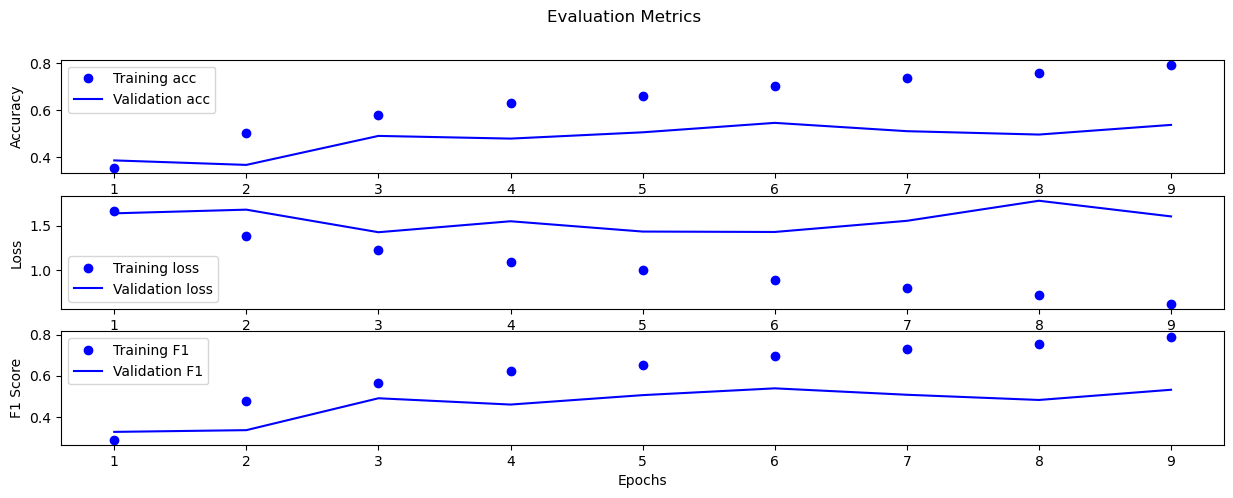

In [23]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

Epoch 1/100
47/47 [==============================] - 3s 49ms/step - loss: 2.7835 - accuracy: 0.3050 - f1_score: 0.2249 - val_loss: 2.2082 - val_accuracy: 0.2867 - val_f1_score: 0.1806
Epoch 2/100
47/47 [==============================] - 1s 29ms/step - loss: 1.8660 - accuracy: 0.3966 - f1_score: 0.2967 - val_loss: 2.0231 - val_accuracy: 0.3010 - val_f1_score: 0.2125
Epoch 3/100
47/47 [==============================] - 1s 29ms/step - loss: 1.6977 - accuracy: 0.4566 - f1_score: 0.3670 - val_loss: 1.8598 - val_accuracy: 0.3886 - val_f1_score: 0.3089
Epoch 4/100
47/47 [==============================] - 1s 29ms/step - loss: 1.5759 - accuracy: 0.5005 - f1_score: 0.4091 - val_loss: 1.8348 - val_accuracy: 0.3876 - val_f1_score: 0.3108
Epoch 5/100
47/47 [==============================] - 1s 30ms/step - loss: 1.5019 - accuracy: 0.5277 - f1_score: 0.4507 - val_loss: 1.8567 - val_accuracy: 0.4114 - val_f1_score: 0.3344
Epoch 6/100
47/47 [==============================] - 1s 30ms/step - loss: 1.4137

'Internal validation accuracy: 40.57%'

'Internal validation F1 score: 0.3442'

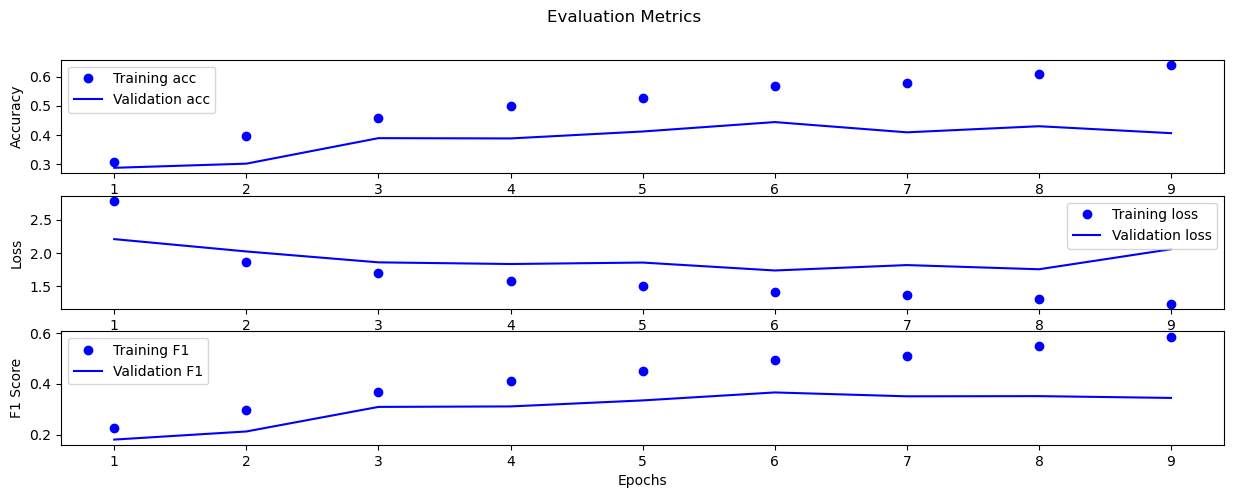

In [24]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

### Keras Vectorization

Epoch 1/100
47/47 [==============================] - 2s 36ms/step - loss: 5.8896 - accuracy: 0.2217 - f1_score: 0.2227 - val_loss: 3.1372 - val_accuracy: 0.1295 - val_f1_score: 0.1098
Epoch 2/100
47/47 [==============================] - 1s 24ms/step - loss: 2.2419 - accuracy: 0.2724 - f1_score: 0.2583 - val_loss: 2.2697 - val_accuracy: 0.1952 - val_f1_score: 0.1694
Epoch 3/100
47/47 [==============================] - 1s 23ms/step - loss: 2.0209 - accuracy: 0.3113 - f1_score: 0.2779 - val_loss: 2.1310 - val_accuracy: 0.2610 - val_f1_score: 0.2303
Epoch 4/100
47/47 [==============================] - 1s 23ms/step - loss: 1.8740 - accuracy: 0.3385 - f1_score: 0.2911 - val_loss: 1.9894 - val_accuracy: 0.3048 - val_f1_score: 0.2295
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 1.8284 - accuracy: 0.3519 - f1_score: 0.2956 - val_loss: 2.1096 - val_accuracy: 0.2886 - val_f1_score: 0.2098
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 1.8121

'Internal validation accuracy: 30.19%'

'Internal validation F1 score: 0.2271'

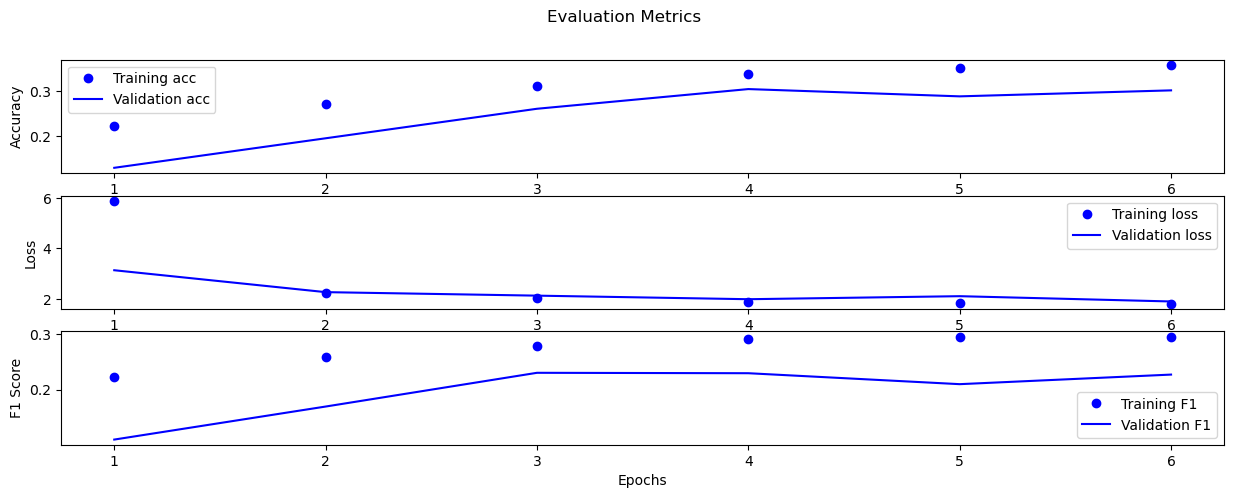

In [25]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVecMAX)

Epoch 1/100
47/47 [==============================] - 4s 66ms/step - loss: 14.8384 - accuracy: 0.2447 - f1_score: 0.2309 - val_loss: 4.2826 - val_accuracy: 0.2895 - val_f1_score: 0.2285
Epoch 2/100
47/47 [==============================] - 2s 47ms/step - loss: 4.0282 - accuracy: 0.2965 - f1_score: 0.2554 - val_loss: 3.7460 - val_accuracy: 0.2286 - val_f1_score: 0.1823
Epoch 3/100
47/47 [==============================] - 2s 47ms/step - loss: 3.1969 - accuracy: 0.3269 - f1_score: 0.2718 - val_loss: 2.8948 - val_accuracy: 0.2848 - val_f1_score: 0.1818
Epoch 4/100
47/47 [==============================] - 2s 46ms/step - loss: 2.5102 - accuracy: 0.3439 - f1_score: 0.2759 - val_loss: 2.4672 - val_accuracy: 0.2924 - val_f1_score: 0.2008


'Internal validation accuracy: 29.24%'

'Internal validation F1 score: 0.2008'

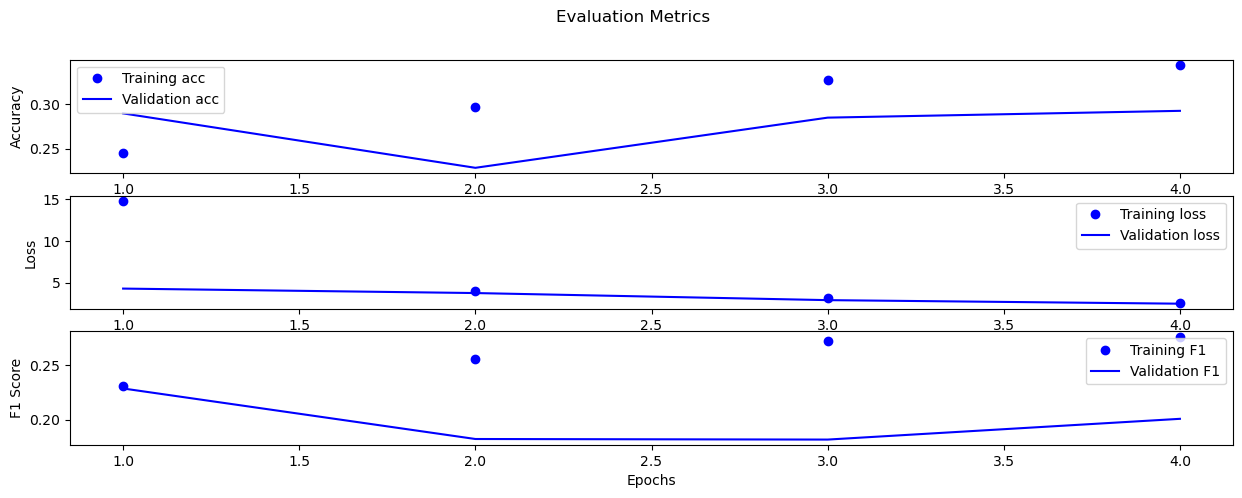

In [26]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVecMAX)

Epoch 1/100
47/47 [==============================] - 2s 32ms/step - loss: 4.0675 - accuracy: 0.2385 - f1_score: 0.2297 - val_loss: 2.3154 - val_accuracy: 0.2057 - val_f1_score: 0.1805
Epoch 2/100
47/47 [==============================] - 1s 25ms/step - loss: 2.0057 - accuracy: 0.2721 - f1_score: 0.2428 - val_loss: 2.1914 - val_accuracy: 0.2381 - val_f1_score: 0.1861
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 1.8589 - accuracy: 0.3074 - f1_score: 0.2633 - val_loss: 1.9274 - val_accuracy: 0.2210 - val_f1_score: 0.1581
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 1.8012 - accuracy: 0.3267 - f1_score: 0.2751 - val_loss: 1.9526 - val_accuracy: 0.2467 - val_f1_score: 0.1536
Epoch 5/100
47/47 [==============================] - 1s 21ms/step - loss: 1.7750 - accuracy: 0.3361 - f1_score: 0.2736 - val_loss: 1.9510 - val_accuracy: 0.2781 - val_f1_score: 0.1838


'Internal validation accuracy: 27.81%'

'Internal validation F1 score: 0.1838'

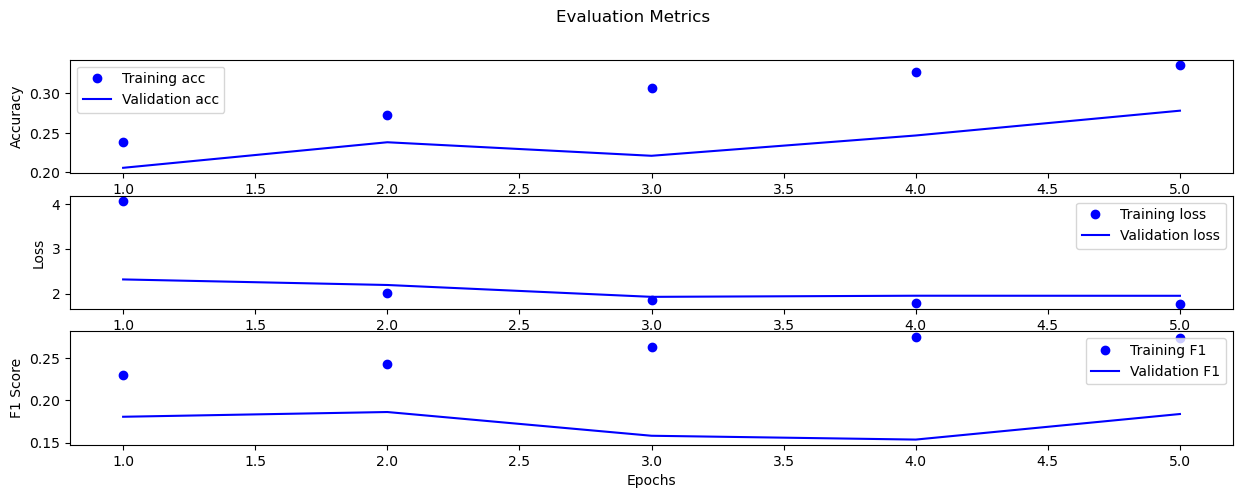

In [27]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Epoch 1/100
47/47 [==============================] - 4s 56ms/step - loss: 11.1625 - accuracy: 0.2603 - f1_score: 0.2307 - val_loss: 4.0595 - val_accuracy: 0.2886 - val_f1_score: 0.2270
Epoch 2/100
47/47 [==============================] - 2s 34ms/step - loss: 3.7345 - accuracy: 0.2901 - f1_score: 0.2386 - val_loss: 3.5341 - val_accuracy: 0.2619 - val_f1_score: 0.1708
Epoch 3/100
47/47 [==============================] - 2s 35ms/step - loss: 2.9503 - accuracy: 0.3182 - f1_score: 0.2526 - val_loss: 2.6594 - val_accuracy: 0.2552 - val_f1_score: 0.1993
Epoch 4/100
47/47 [==============================] - 2s 33ms/step - loss: 2.4046 - accuracy: 0.3249 - f1_score: 0.2502 - val_loss: 2.3107 - val_accuracy: 0.2762 - val_f1_score: 0.2068


'Internal validation accuracy: 27.62%'

'Internal validation F1 score: 0.2068'

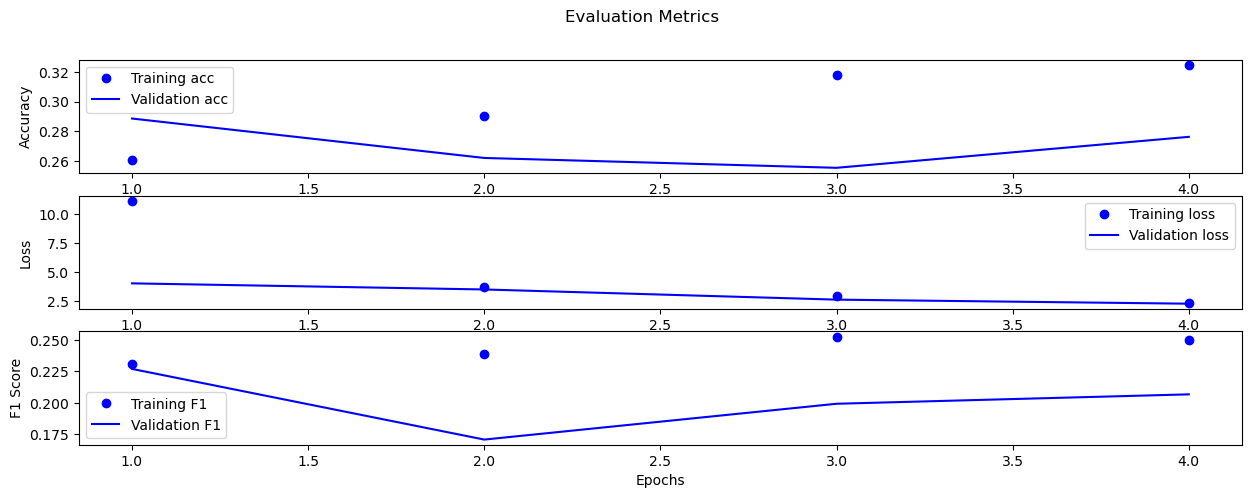

In [28]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Epoch 1/100
47/47 [==============================] - 2s 38ms/step - loss: 3.1445 - accuracy: 0.2405 - f1_score: 0.2238 - val_loss: 2.0678 - val_accuracy: 0.2362 - val_f1_score: 0.1620
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 1.9225 - accuracy: 0.2911 - f1_score: 0.2484 - val_loss: 2.2551 - val_accuracy: 0.2295 - val_f1_score: 0.1213
Epoch 3/100
47/47 [==============================] - 1s 21ms/step - loss: 1.8366 - accuracy: 0.3094 - f1_score: 0.2514 - val_loss: 1.9360 - val_accuracy: 0.2476 - val_f1_score: 0.1861
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 1.8016 - accuracy: 0.3138 - f1_score: 0.2492 - val_loss: 1.9040 - val_accuracy: 0.2371 - val_f1_score: 0.1452
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 1.7681 - accuracy: 0.3287 - f1_score: 0.2550 - val_loss: 1.8856 - val_accuracy: 0.2762 - val_f1_score: 0.2004
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 1.7486

'Internal validation accuracy: 27.71%'

'Internal validation F1 score: 0.1972'

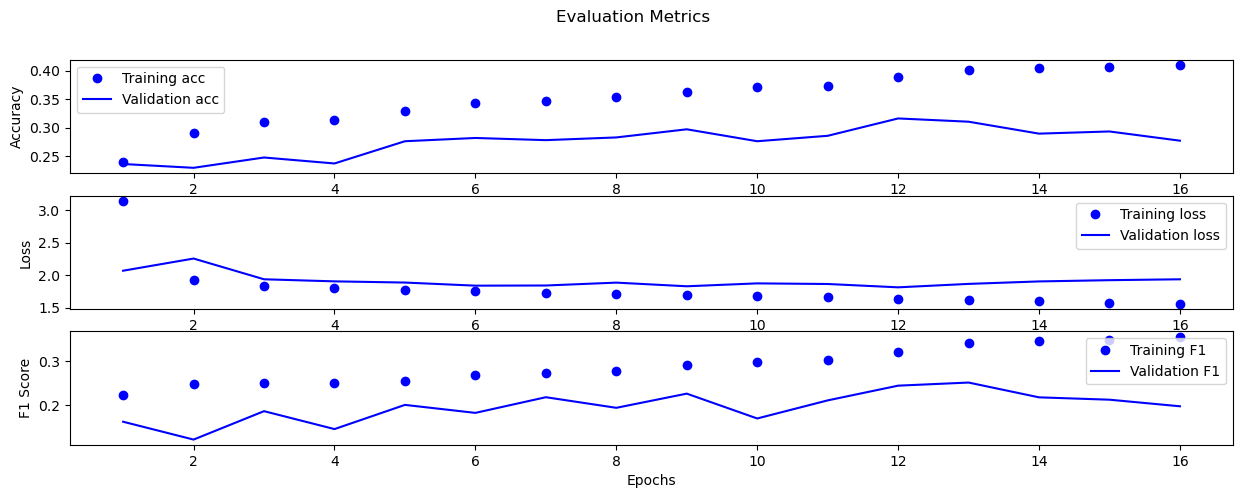

In [29]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec500)

Epoch 1/100
47/47 [==============================] - 4s 56ms/step - loss: 7.9693 - accuracy: 0.2664 - f1_score: 0.2255 - val_loss: 4.0138 - val_accuracy: 0.2210 - val_f1_score: 0.1333
Epoch 2/100
47/47 [==============================] - 2s 32ms/step - loss: 3.5129 - accuracy: 0.3061 - f1_score: 0.2339 - val_loss: 3.1782 - val_accuracy: 0.2276 - val_f1_score: 0.1193
Epoch 3/100
47/47 [==============================] - 2s 35ms/step - loss: 2.7134 - accuracy: 0.3244 - f1_score: 0.2431 - val_loss: 2.4557 - val_accuracy: 0.2686 - val_f1_score: 0.1772
Epoch 4/100
47/47 [==============================] - 2s 33ms/step - loss: 2.2497 - accuracy: 0.3365 - f1_score: 0.2505 - val_loss: 2.1910 - val_accuracy: 0.2867 - val_f1_score: 0.1823
Epoch 5/100
47/47 [==============================] - 1s 32ms/step - loss: 2.0258 - accuracy: 0.3457 - f1_score: 0.2522 - val_loss: 2.0606 - val_accuracy: 0.2714 - val_f1_score: 0.1700
Epoch 6/100
47/47 [==============================] - 1s 31ms/step - loss: 1.9131

'Internal validation accuracy: 28.0%'

'Internal validation F1 score: 0.1682'

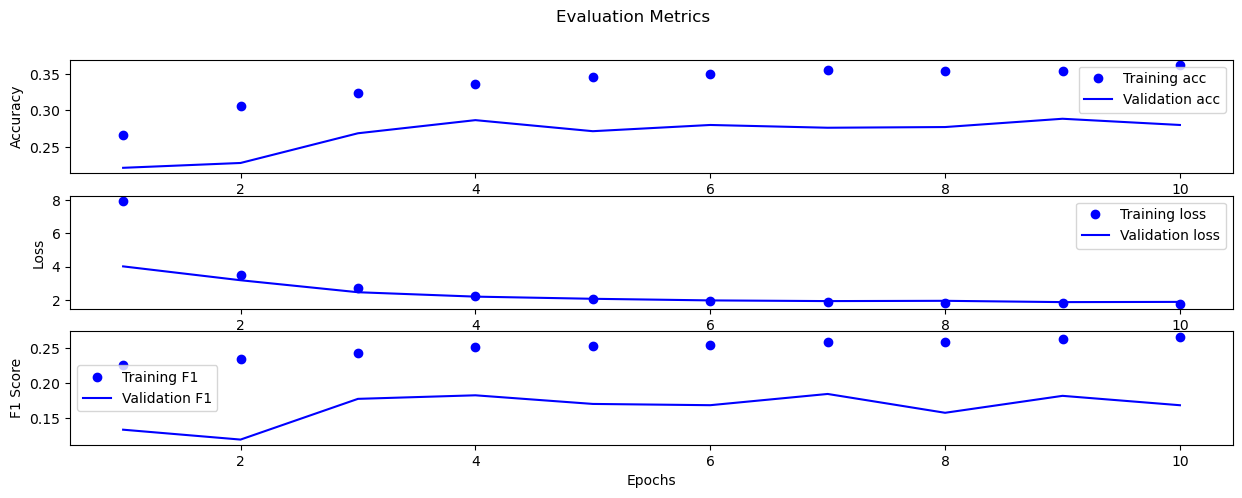

In [30]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec500)

Epoch 1/100
47/47 [==============================] - 3s 38ms/step - loss: 1.9604 - accuracy: 0.2879 - f1_score: 0.2332 - val_loss: 1.9534 - val_accuracy: 0.2514 - val_f1_score: 0.1604
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 1.7743 - accuracy: 0.3413 - f1_score: 0.2681 - val_loss: 1.8623 - val_accuracy: 0.2390 - val_f1_score: 0.1406
Epoch 3/100
47/47 [==============================] - 1s 24ms/step - loss: 1.7412 - accuracy: 0.3462 - f1_score: 0.2765 - val_loss: 1.7852 - val_accuracy: 0.3257 - val_f1_score: 0.2891
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 1.7065 - accuracy: 0.3733 - f1_score: 0.3127 - val_loss: 1.8542 - val_accuracy: 0.2829 - val_f1_score: 0.2224
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 1.6821 - accuracy: 0.3788 - f1_score: 0.3160 - val_loss: 1.7764 - val_accuracy: 0.3248 - val_f1_score: 0.2878
Epoch 6/100
47/47 [==============================] - 1s 21ms/step - loss: 1.6507

'Internal validation accuracy: 28.57%'

'Internal validation F1 score: 0.2313'

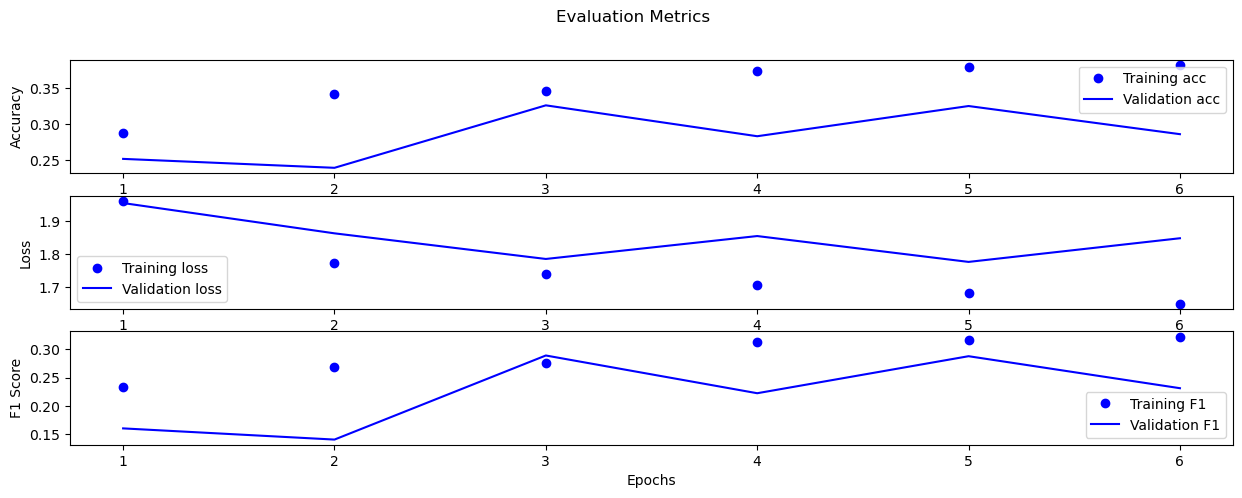

In [31]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)

Epoch 1/100
47/47 [==============================] - 4s 56ms/step - loss: 4.3326 - accuracy: 0.2973 - f1_score: 0.2284 - val_loss: 3.4509 - val_accuracy: 0.2562 - val_f1_score: 0.1305
Epoch 2/100
47/47 [==============================] - 2s 34ms/step - loss: 2.8005 - accuracy: 0.3195 - f1_score: 0.2335 - val_loss: 2.4787 - val_accuracy: 0.2457 - val_f1_score: 0.1531
Epoch 3/100
47/47 [==============================] - 2s 35ms/step - loss: 2.2069 - accuracy: 0.3333 - f1_score: 0.2443 - val_loss: 2.0764 - val_accuracy: 0.3181 - val_f1_score: 0.2525
Epoch 4/100
47/47 [==============================] - 2s 36ms/step - loss: 1.9551 - accuracy: 0.3464 - f1_score: 0.2565 - val_loss: 1.9990 - val_accuracy: 0.2371 - val_f1_score: 0.1241
Epoch 5/100
47/47 [==============================] - 2s 34ms/step - loss: 1.8455 - accuracy: 0.3553 - f1_score: 0.2738 - val_loss: 1.9094 - val_accuracy: 0.2971 - val_f1_score: 0.2317
Epoch 6/100
47/47 [==============================] - 1s 31ms/step - loss: 1.7944

'Internal validation accuracy: 28.95%'

'Internal validation F1 score: 0.248'

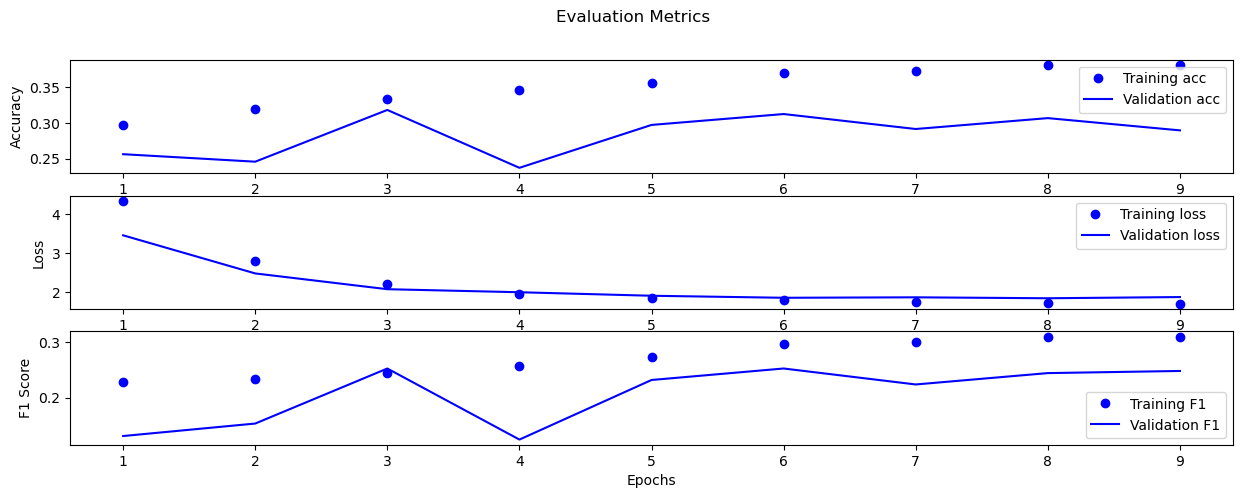

In [32]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)

### Embeddings

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4977, 128)         637056    
                                                                 
 flatten (Flatten)           (None, 637056)            0         
                                                                 
 dense (Dense)               (None, 128)               81543296  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 82,189,063
Trainable params: 82,189,063
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=========================

'Internal validation accuracy: 22.19%'

'Internal validation F1 score: 0.0806'

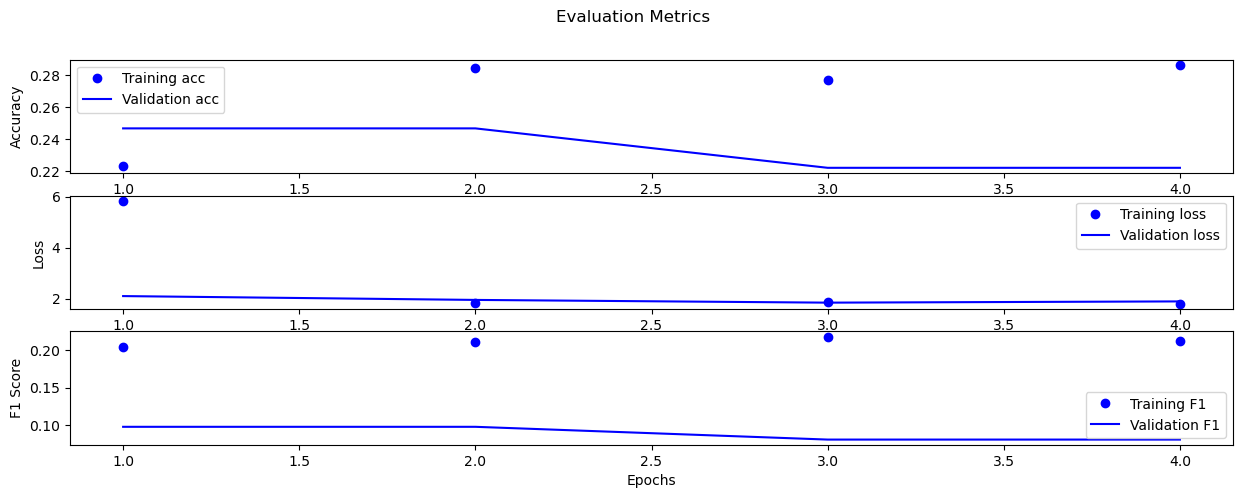

In [15]:
# define model architecture
model = Sequential([
    Embedding(4977, 128, input_shape = (4977, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vecMAX)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 128)         128000    
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               16384128  
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 16,520,839
Trainable params: 16,520,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=======================

'Internal validation accuracy: 22.19%'

'Internal validation F1 score: 0.0806'

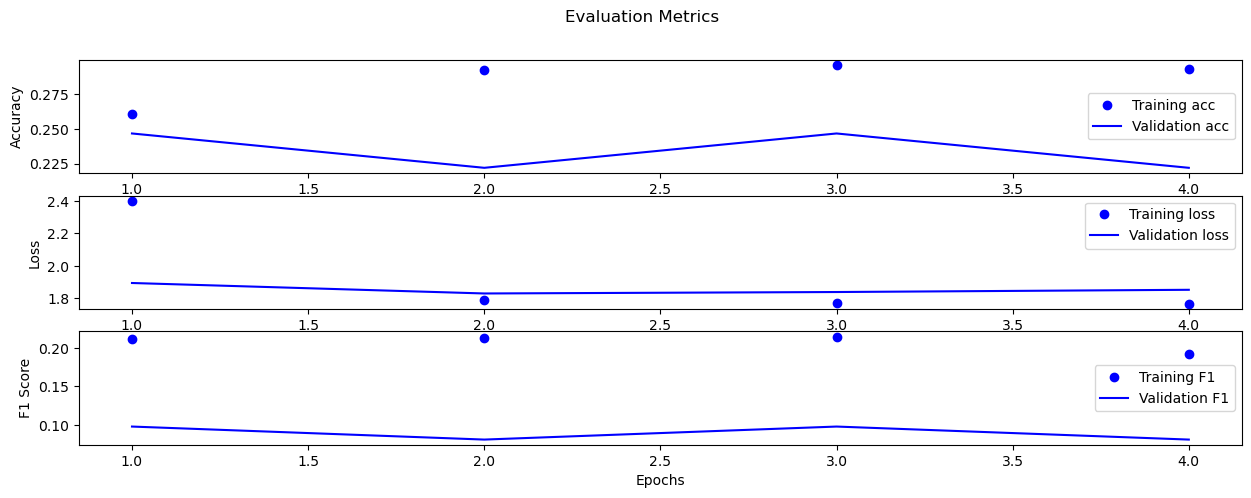

In [16]:
# define model architecture
model = Sequential([
    Embedding(1000, 128, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 128)          64000     
                                                                 
 flatten_2 (Flatten)         (None, 64000)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               8192128   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 7)                 455       
                                                                 
Total params: 8,264,839
Trainable params: 8,264,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=========================

'Internal validation accuracy: 22.19%'

'Internal validation F1 score: 0.0806'

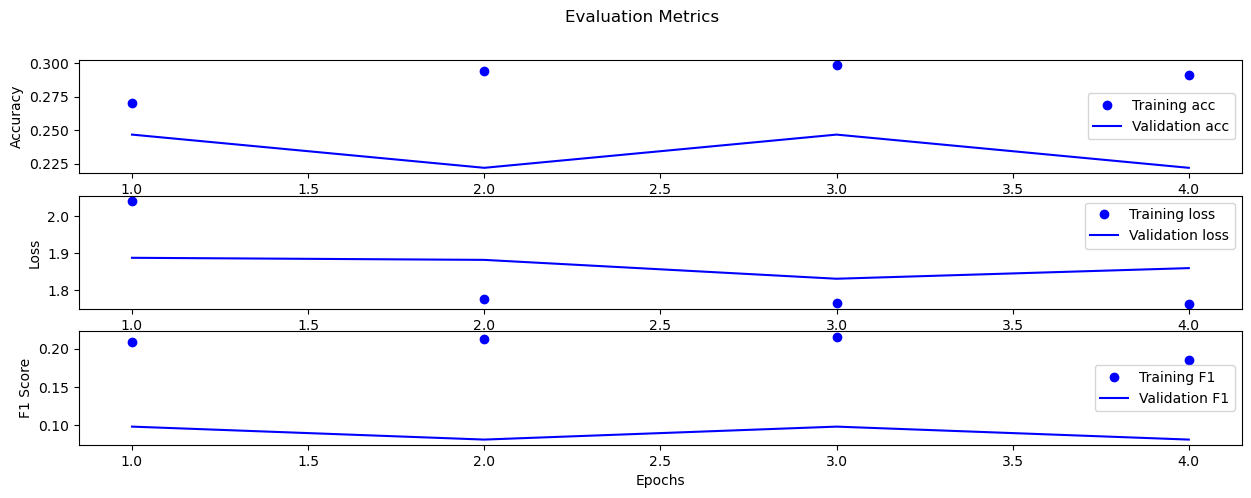

In [17]:
# define model architecture
model = Sequential([
    Embedding(500, 128, input_shape = (500, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec500)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          12800     
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               1638528   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 7)                 455       
                                                                 
Total params: 1,660,039
Trainable params: 1,660,039
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=========================

'Internal validation accuracy: 22.19%'

'Internal validation F1 score: 0.0806'

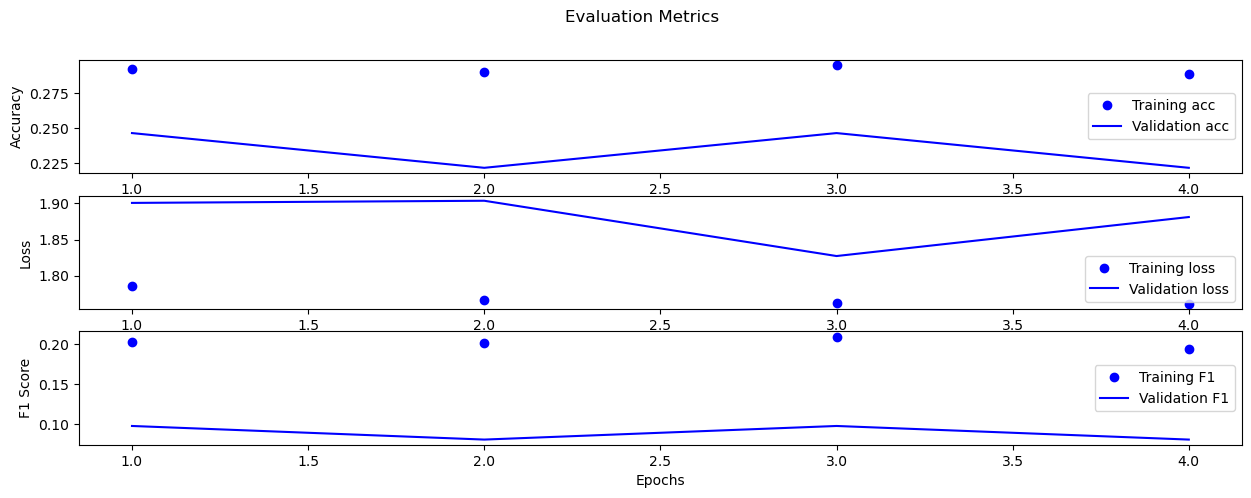

In [18]:
# define model architecture
model = Sequential([
    Embedding(100, 128, input_shape = (100, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4977, 128)         637056    
                                                                 
 flatten_4 (Flatten)         (None, 637056)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               81543296  
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 7)                 455       
                                                                 
Total params: 82,189,063
Trainable params: 82,189,063
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=======================

'Internal validation accuracy: 73.24%'

'Internal validation F1 score: 0.7288'

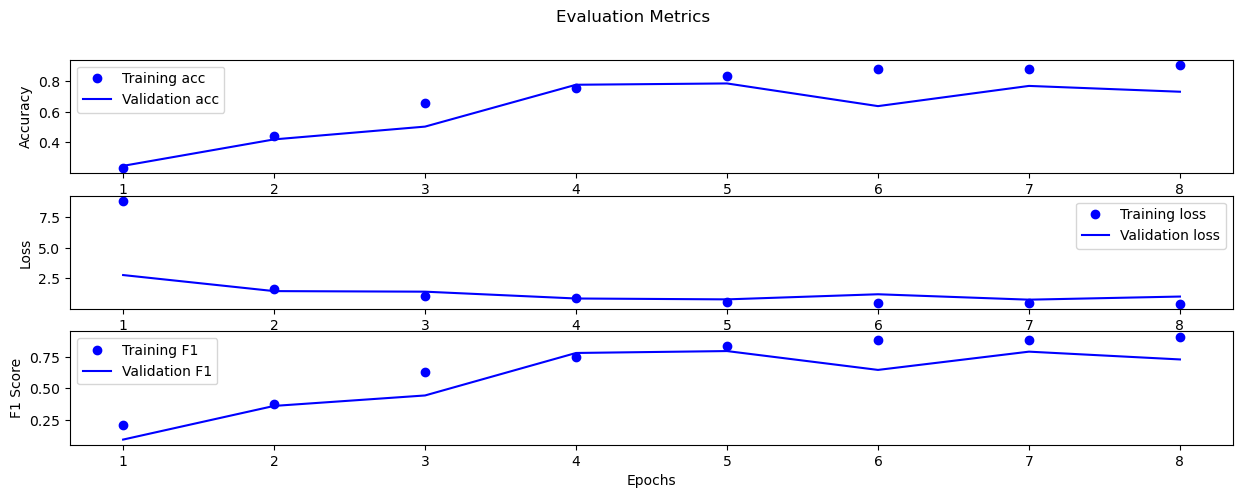

In [19]:
# define model architecture
model = Sequential([
    Embedding(4977, 128, input_shape = (4977, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVecMAX)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 128)         128000    
                                                                 
 flatten_5 (Flatten)         (None, 128000)            0         
                                                                 
 dense_15 (Dense)            (None, 128)               16384128  
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 7)                 455       
                                                                 
Total params: 16,520,839
Trainable params: 16,520,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=======================

'Internal validation accuracy: 83.52%'

'Internal validation F1 score: 0.8361'

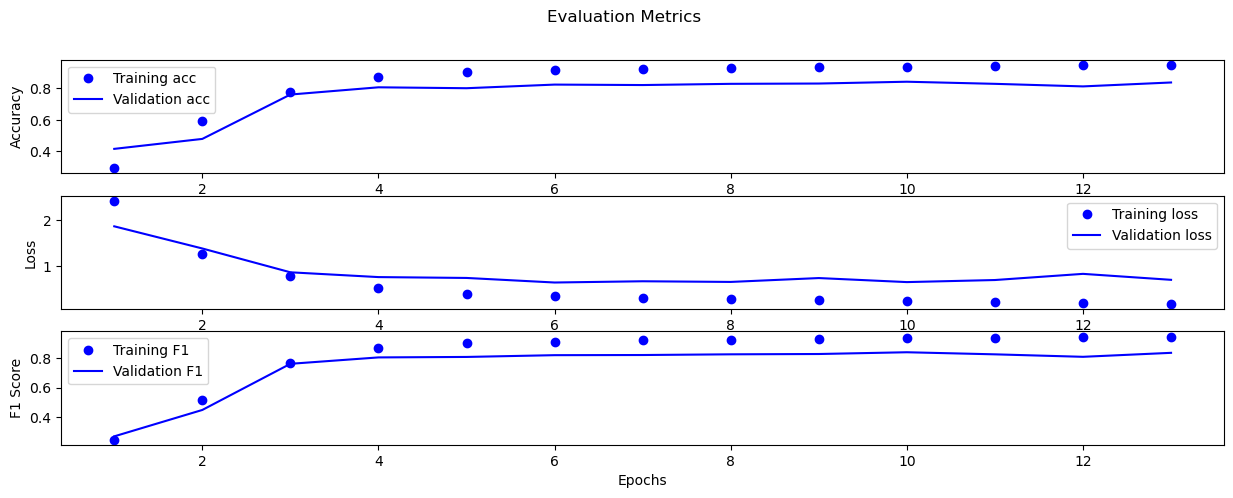

In [20]:
# define model architecture
model = Sequential([
    Embedding(1000, 128, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 500, 128)          64000     
                                                                 
 flatten_6 (Flatten)         (None, 64000)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               8192128   
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 7)                 455       
                                                                 
Total params: 8,264,839
Trainable params: 8,264,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=========================

'Internal validation accuracy: 79.52%'

'Internal validation F1 score: 0.795'

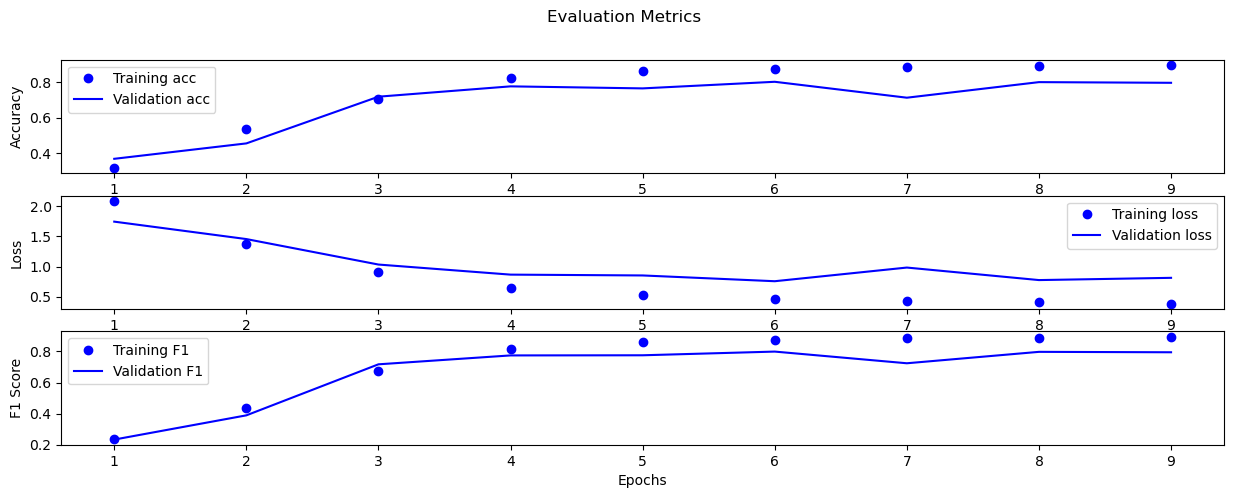

In [21]:
# define model architecture
model = Sequential([
    Embedding(500, 128, input_shape = (500, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec500)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 128)          12800     
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dense_21 (Dense)            (None, 128)               1638528   
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 7)                 455       
                                                                 
Total params: 1,660,039
Trainable params: 1,660,039
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [=========================

'Internal validation accuracy: 62.38%'

'Internal validation F1 score: 0.6493'

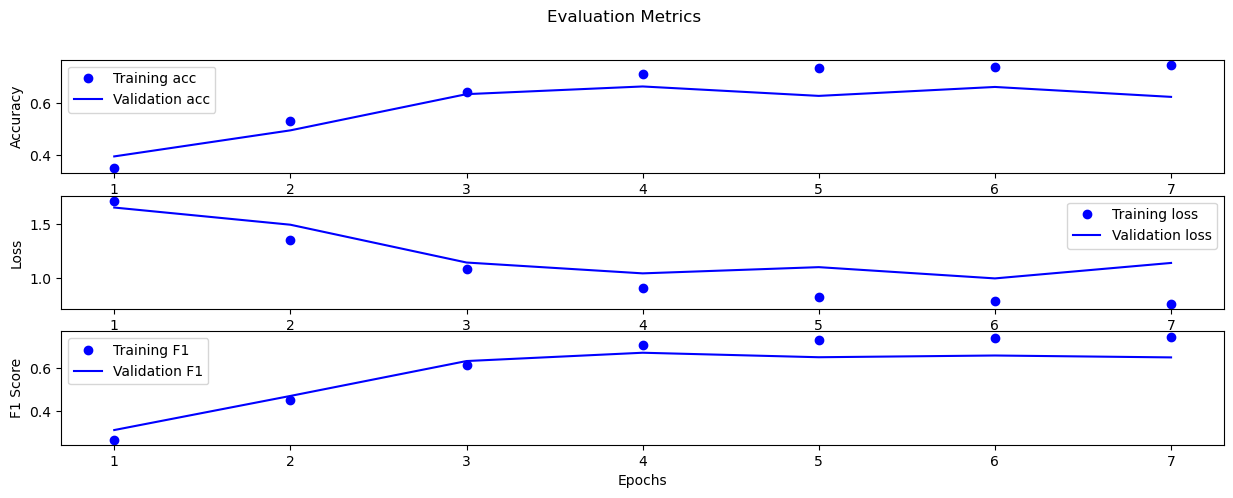

In [22]:
# define model architecture
model = Sequential([
    Embedding(100, 128, input_shape = (100, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)

### RNNs

In [9]:
# define model architecture
model = Sequential([
    Embedding(1000, 8, input_shape = (1000, )),
    SimpleRNN(32),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         128000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 146,087
Trainable params: 146,087
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 2/47 [>.............................]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            800       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1312      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 15,047
Trainable params: 15,047
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] -

'Internal validation accuracy: 22.19%'

'Internal validation F1 score: 0.0806'

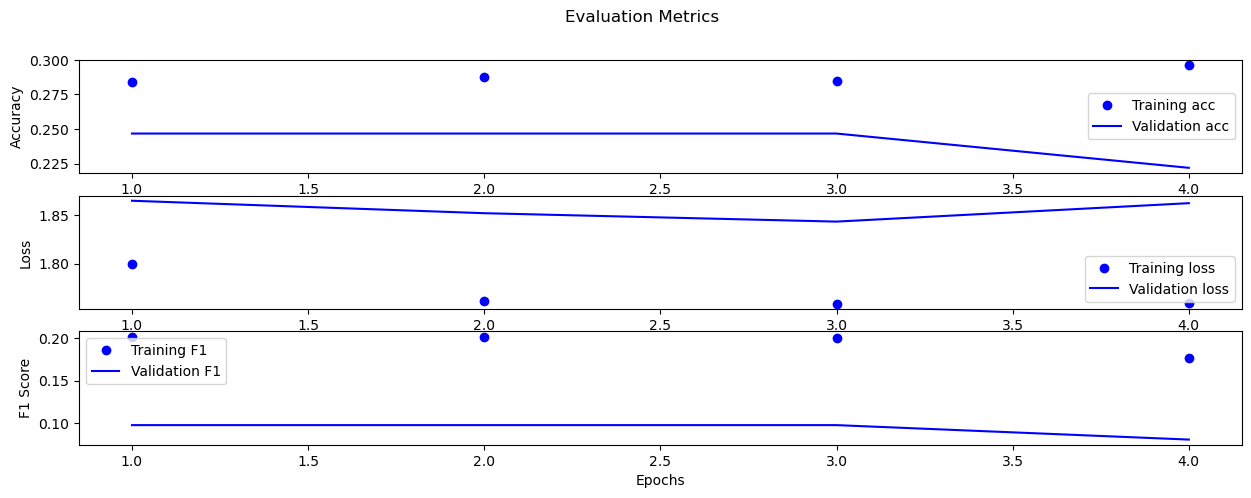

In [9]:
# define model architecture
model = Sequential([
    Embedding(100, 8, input_shape = (100, )),
    SimpleRNN(32),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

In [ ]:
# define model architecture
model = Sequential([
    Embedding(1000, 8, input_shape = (1000, )),
    SimpleRNN(32),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 8)            800       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1312      
                                                                 
 dense_3 (Dense)             (None, 128)               4224      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 15,047
Trainable params: 15,047
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================]

'Internal validation accuracy: 23.14%'

'Internal validation F1 score: 0.1202'

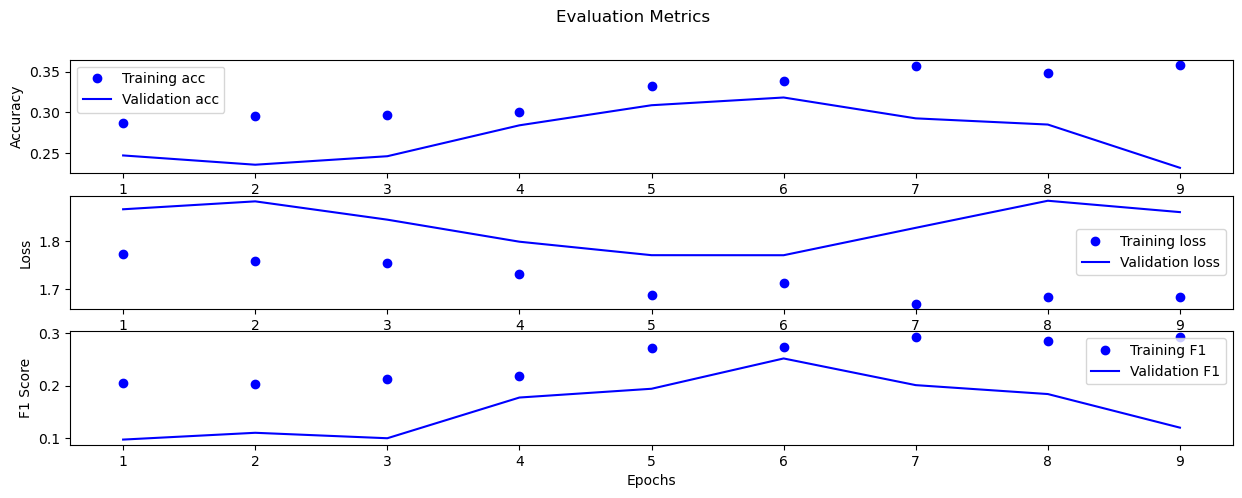

In [10]:
# define model architecture
model = Sequential([
    Embedding(100, 8, input_shape = (100, )),
    SimpleRNN(32),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 8)            800       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 100, 32)           1312      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 100, 32)           2080      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 8,839
Trainable params: 8,839
Non-traina

'Internal validation accuracy: 62.86%'

'Internal validation F1 score: 0.6264'

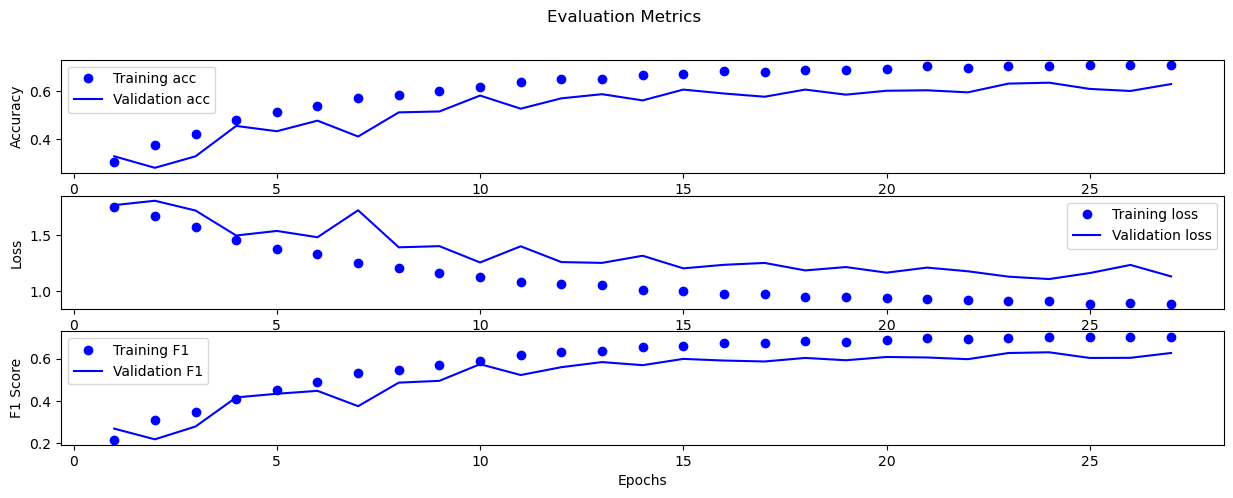

In [12]:
# define model architecture
model = Sequential([
    Embedding(100, 8, input_shape = (100, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)